In [59]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
print(plt_styles)

plt.style.use(plt_styles[7])


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [60]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [61]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [62]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [63]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [64]:
toolbox = base.Toolbox()
history = tools.History()

In [65]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [66]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [67]:
def get_pareto_front(pop):
    fitness = []
    penalty = []
    pairs = []

    # Get fitness and penalty.
    for ind in pop:
        f, p = eval_ind(ind)
        fitness.append(f)
        penalty.append(p)
        pairs.append([f, p])

    # Get frontier.
    sorted_pairs = sorted(pairs, reverse=True)
    front = [sorted_pairs[0]]

    for pair in sorted_pairs[1:]:
        if pair[1] <= front[-1][1]:
            front.append(pair)

    f_front = [f for f, _ in front]
    p_front = [p for _, p in front]

    _, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(fitness, penalty, alpha=0.6, label="Population")
    ax.plot(f_front, p_front, color="b", alpha=0.5, label="Pareto Front")
    ax.tick_params(axis="x", rotation=30)
    ax.set_ylabel("Penalty")
    ax.set_xlabel("Fitness")

    legend = plt.legend(loc="best", shadow=True, edgecolor="black",
                        borderpad=1, labelspacing=0.8, facecolor="whitesmoke")
    plt.setp(legend.get_texts(), color="black")
    plt.show()


def plot_dif_scales(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    mins = lb.select("min")
    maxs = lb.select("max")

    fit_avgs, pen_avgs = col(avgs, 0, 1)
    fit_maxs, pen_maxs = col(maxs, 0, 1)
    fit_mins, pen_mins = col(mins, 0, 1)

    _, ax = plt.subplots(figsize=(6, 4))

    c_ax, c_ax2 = ["r", "b"]
    linewidth = 2
    line_alpha = 0.6
    grid_alpha = 0.1

    ax.plot(gen, fit_avgs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_maxs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_mins, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.tick_params(axis="y", labelcolor=c_ax)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness", color=c_ax)
    ax.grid(alpha=grid_alpha, color=c_ax)

    ax2 = ax.twinx()
    ax2.plot(gen, pen_avgs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_maxs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_mins, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.tick_params(axis="y", labelcolor=c_ax2)
    ax2.set_ylabel("Penalty", color=c_ax2)
    ax2.grid(alpha=grid_alpha, color=c_ax2)

    plt.show()


In [68]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


def get_penalty(adapted_car, adapted_ride):
    if adapted_car == 0 and adapted_ride == 0:
        return - B*0.2
    
    if adapted_car == 0 and adapted_ride == 1:
        return B

    if adapted_car == 1 and adapted_ride == 0:
        return B*0.5


    if adapted_car == 1 and adapted_ride == 1:
        return - B*0.4


In [69]:
def calc_fitness(car, car_rides):
    fitness = 0
    penalty = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, adapted_ride = ride
        origin = [a, b]
        destiny = [x, y]

        adapted_car = adapted[car]

        # 0.- Set penalty of adaptability of car/ride.
        penalty += get_penalty(adapted_car, adapted_ride)

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness, penalty


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0
    penalty = 0

    for car, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness, _penalty = calc_fitness(car, car_rides)
            fitness += _fitness
            penalty += _penalty

    return fitness, penalty


In [70]:

INDPB = 0.2

toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)

toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

In [71]:
NIND = 300

pop = toolbox.population(n=NIND)
hof = tools.ParetoFront()
history.update(pop)

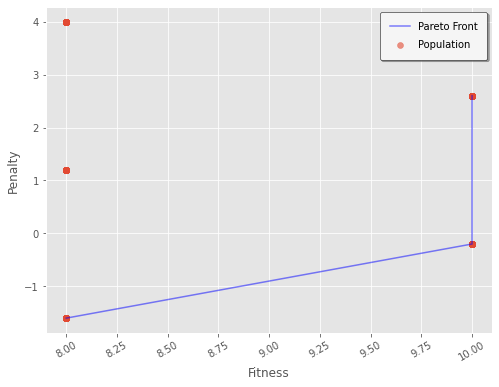

In [72]:
# Pareto front from first population.
get_pareto_front(pop)

In [73]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")

Individuo
[0, 1]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (8.0, -1.6)


In [74]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
stats.register("std", np.std, axis=0)
stats.register("avg", np.average, axis=0)


In [75]:
NGEN = 10
MU = 50
LAMBDA = 2*MU
CXPB = 0.8
MUTPB = 0.1

pop, logbook = algorithms.eaMuPlusLambda(
    pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof, verbose=False)

In [76]:
best_sol = tools.selBest(pop, k=1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)}")


El resultado de la evolución es:
gen	nevals	min        	max        	std                    	avg            
0  	300   	[ 8.  -1.6]	[10.  4.]  	[0.99498744 1.67409797]	[9.1   1.186]  
1  	93    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
2  	87    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
3  	89    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
4  	90    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
5  	91    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
6  	89    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
7  	90    	[ 8.  -1.6]	[10.  -0.2]	[0.28  0.196]          	[ 9.96  -0.228]
8  	88    	[ 8.  -1.6]	[10.  -0.2]	[0.28  0.196]          	[ 9.96  -0.228]
9  	95    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
10 	89    	[ 8.  -1.6]	[10.  -0.2]	[0.39191836 0.27434285]	[ 9.92  -0.256]
Mejor solución es [0, 0] con fitness (10, -0.20000000000000007)


In [77]:
def col(a, *n_cols):
    cols = []
    for n in n_cols:
        col = np.array(a)[:, n]
        cols.append(col)
    return cols

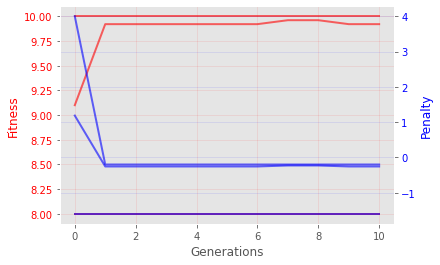

In [78]:
plot_dif_scales(logbook)


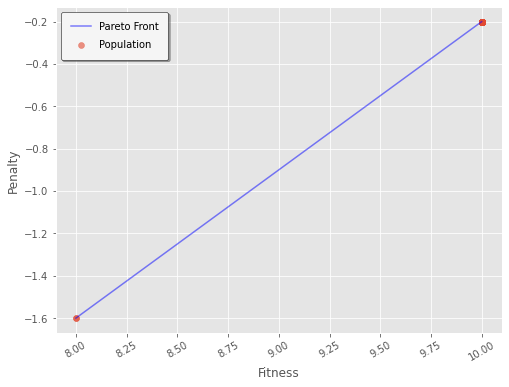

In [79]:
# Pareto front from last population.
get_pareto_front(pop)


KeyboardInterrupt: 

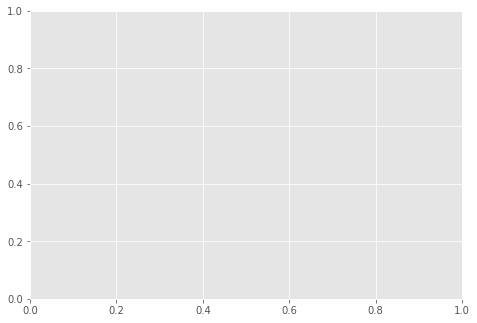

In [88]:
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx


graph = nx.DiGraph(history.genealogy_tree)
graph = graph.reverse()     # Make the grah top-down
# colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
# nx.draw(graph, node_color=colors)
nx.draw(graph)
plt.show()

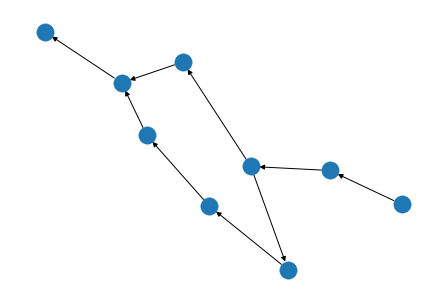

In [81]:
g = nx.DiGraph([('P', 'I0'), ('I0', 'I1'), ('I1', 'I2'),
                ('I2', 'I3'), ('I1', 'I5'), ('I5', 'C7'),
                ('C7', 'C6'), ('C6', 'I3'), ('I3', 'C9')])

nx.draw(g)
plt.show()

In [82]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")